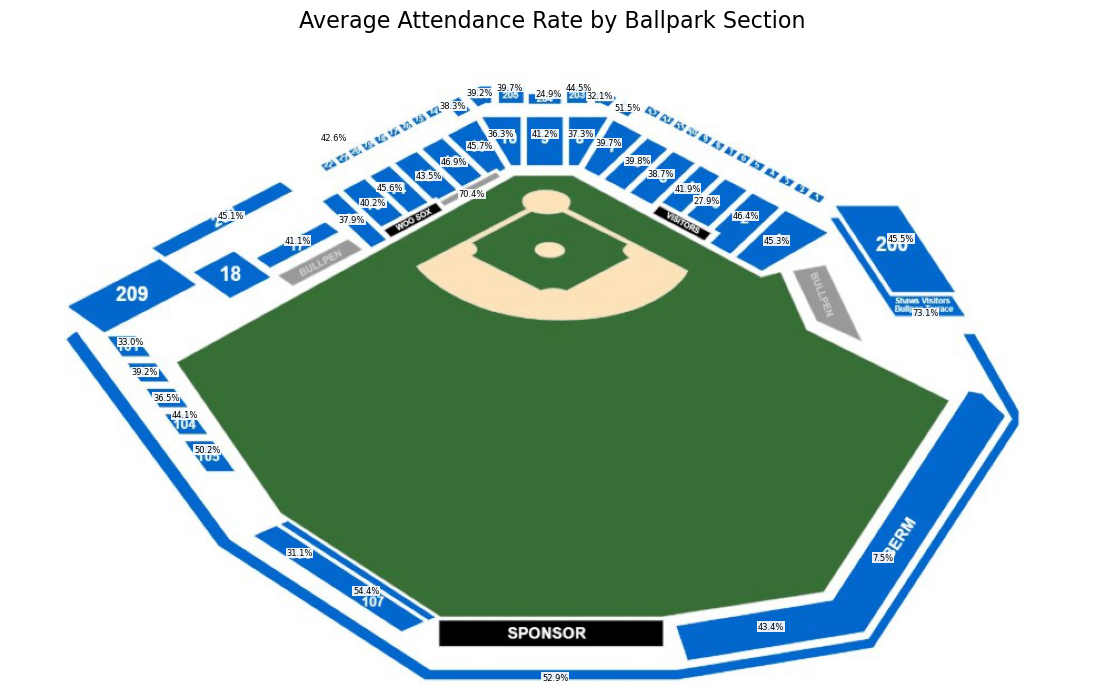

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the CSV file
data = pd.read_csv(r"C:\Users\Busti\OneDrive - Worcester Polytechnic Institute (wpi.edu)\MQP\MQP Python\sales_report_updated.csv", low_memory=False)

# Ensure EVENT_USAGE_DATE is in datetime format
data['EVENT_USAGE_DATE'] = pd.to_datetime(data['EVENT_USAGE_DATE'])

# Filter out specific event dates
exclude_dates = pd.to_datetime(['2024-04-02', '2024-07-04'])
data = data[~data['EVENT_USAGE_DATE'].isin(exclude_dates)]

# Section capacity data (as in your original code)
section_capacity = {
    "Section 1": 393, "Section 2": 278, "Section 3": 314, "Section 4": 185, "Section 5": 319,
    "Section 6": 279, "Section 7": 366, "Section 8": 275, "Section 9": 403, "Section 10": 296,
    "Section 11": 361, "Section 12": 241, "Section 13": 298, "Section 14": 231, "Section 15": 261,
    "Section 16": 121, "Suites": 460, "Bridge": 35, "Section 201": 36, "Section 202": 46,
    "Section 203": 59, "Section 204": 48, "Section 205": 77, "Section 206": 79, "Section 207": 55,
    "Section 101": 46, "Section 102": 50, "Section 103": 50, "Section 104": 50, "Section 105": 65,
    "Yuengling Flight Deck": 34, "Shaw's Home Bullpen Terrace": 100, "Triple Decker Garden": 150,
    "Flexcon Landing": 100, "Hanover Deck": 225, "Shaw's Visitors Bullpen Terrace": 200,
    "University Dental Group Berm": 700, "Big Blue Bug Batter's Box": 15, "General Admission": 5000
}

# Coordinates for each section on the ballpark blueprint
section_coordinates = {
    "Section 1": (689,184), "Section 2": (661,162), "Section 3": (626,148), "Section 4": (609,137),
    "Section 5": (585,124), "Section 6": (564,112), "Section 7": (538,96), "Section 8": (513,88),
    "Section 9": (481,88), "Section 10": (441,88), "Section 11": (422,99), "Section 12": (399,113),
    "Section 13": (376,126), "Section 14": (341,136), "Section 15": (326,150), "Section 16": (307,165),
    "Suites": (291,91), "Bridge": (198,162), "Section 201": (555,64), "Section 202": (530,54),
    "Section 203": (511,46), "Section 204": (484,52), "Section 205": (449,46), "Section 206": (422,51),
    "Section 207": (398,63), "Section 101": (108,275), "Section 102": (121,302), "Section 103": (140,325),
    "Section 104": (157,341), "Section 105": (177,372), "Yuengling Flight Deck": (490,577),
    "Shaw's Home Bullpen Terrace": (258,184), "Triple Decker Garden": (260,465),
    "Flexcon Landing": (320,499), "Hanover Deck": (801,182), "Shaw's Visitors Bullpen Terrace": (823,249),
    "University Dental Group Berm": (684,531), "Big Blue Bug Batter's Box": (415,142),
    "General Admission": (785,469)
}

# Load the ballpark blueprint
blueprint_img = mpimg.imread(r"C:\Users\Busti\OneDrive - Worcester Polytechnic Institute (wpi.edu)\MQP\MQP Python\PolarPark_SeatingMap.jpg")  # Update with the actual path

# Widgets for user input
# Ticket type selection
ticket_type_widget = widgets.SelectMultiple(
    options=['S', 'P', 'G'],
    value=['S', 'P', 'G'],  # Default selection
    description='Ticket Types'
)
# Day of week selection
days_widget = widgets.SelectMultiple(
    options=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    value=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],  # Default selection
    description='Days'
)
# Month selection
months_widget = widgets.SelectMultiple(
    options=['March', 'April', 'May', 'June', 'July', 'August', 'September'],
    value=['March', 'April', 'May', 'June', 'July', 'August', 'September'],  # Default selection
    description='Months'
)
# EVENT_USAGE_DATE - TRANSACTION_DATE (days between) selection
days_between_slider = widgets.IntRangeSlider(
    value=[0, 365],  # Default range (same-day tickets)
    min=0,  # Minimum days
    max=365,  # Maximum days
    step=1,
    description='Days Between:',
    continuous_update=False
)
button = widgets.Button(description="Update Plot")

# Callback function to update the plot
def update_plot(button):
    chosen_ticket_types = ticket_type_widget.value
    chosen_days = days_widget.value
    chosen_months = months_widget.value
    min_days, max_days = days_between_slider.value

    # Filter the data by ticket type, day of the week, month, and range of days between dates
    data['Days_Between'] = (data['EVENT_USAGE_DATE'] - pd.to_datetime(data['TRANSACTION_DATE'])).dt.days
    filtered_data = data[
        data['ADJ.PGS'].isin(chosen_ticket_types) & 
        data['GameDay'].isin(chosen_days) & 
        data['Game Month'].isin(chosen_months) & 
        (data['Days_Between'].between(min_days, max_days))
    ]
    filtered_data['Total_Sellable_Capacity'] = filtered_data['SECTION_DESC'].map(section_capacity)

    # Group and calculate attendance rates
    attendance_data = filtered_data.groupby(['SECTION_DESC', 'EVENT_USAGE_DATE']).agg(
        attended=('SCANNED', 'sum'),
        capacity=('Total_Sellable_Capacity', 'first')
    ).reset_index()
    attendance_data['ATTENDANCE_RATE'] = (attendance_data['attended'] / attendance_data['capacity']) * 100
    average_attendance = attendance_data.groupby('SECTION_DESC')['ATTENDANCE_RATE'].mean().reset_index()

    # Plot
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.imshow(blueprint_img)
    for _, row in average_attendance.iterrows():
        section = row['SECTION_DESC']
        attendance_rate = row['ATTENDANCE_RATE']
        if section in section_coordinates:
            x, y = section_coordinates[section]
            ax.text(x, y, f"{attendance_rate:.1f}%", color="black", fontsize=6, ha="center", va="center", 
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, pad=0.5))
    ax.axis('off')
    plt.title("Average Attendance Rate by Ballpark Section", fontsize=16)
    plt.show()

# Bind button to the callback
button.on_click(update_plot)

# Display widgets
display(ticket_type_widget, days_widget, months_widget, days_between_slider, button)
